In [2]:
from pygod.detector import CoLA
from pygod.metric import eval_roc_auc
import scipy.io
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import networkx as nx
import torch
import os
from typing import Tuple, List, Literal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
import pickle
import os
from utils_unsup import set_random_seeds, eval_all
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from tqdm import tqdm



path_model = './saved/models_unsup_ad_0826'
path_out = 'output/unsup_ad'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def save_model(model,filename):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

def read_model(filename):
    with open(filename,'rb') as f:
        return(pickle.load(f))
    
def clear():
    torch.cuda.empty_cache()

def load_data(
        dataname:Literal['YelpHotel','YelpRes','Amazon','YelpNYC'],
        if_split:bool=False,
        split:Tuple[float]=(0.6,0.2,0.2)
    ) -> Tuple[Data,np.ndarray]:
    dataset = scipy.io.loadmat(f'./dataset/{dataname}/{dataname}.mat')
    dataset['Network'].toarray()
    D = nx.DiGraph(dataset['Network'].toarray())
    edges = torch.tensor([[u for (u, v) in D.edges()],[v for (u,v) in D.edges()]], dtype=torch.int64)
    attr = torch.tensor(dataset['Attributes'].toarray(), dtype=torch.float)
    label = torch.tensor(dataset['Label'])
    data = Data(x=attr, edge_index=edges)

    if if_split:
        n = label.shape[0]
        train_mask, val_mask, test_mask = np.zeros(n).astype(bool), np.zeros(n).astype(bool), np.zeros(n).astype(bool)
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        n_train, n_val = int(n*split[0]),int(n*split[1])
        train_mask[indexes[:n_train]] = True
        val_mask[indexes[n_train:(n_train+n_val)]] = True
        test_mask[indexes[(n_train+n_val):]] = True
        train_mask, val_mask, test_mask = torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask)
        data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask
    return data,label

data_src, label_src = load_data('YelpHotel',if_split=True)
data_tgt, label_tgt = load_data('YelpRes',if_split=False)
set_random_seeds(123,device='gpu')

In [55]:
model_CoLA_src = CoLA(gpu=0)
model_CoLA_src.fit(data_src)

CoLA(act=<function relu at 0x7f711c051700>,
     backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
     batch_size=4322, compile_model=False, contamination=0.1, dropout=0.0,
     epoch=100, gpu=None, hid_dim=64, lr=0.004, num_layers=4,
     num_neigh=[-1, -1, -1, -1], save_emb=False, verbose=0,
     weight_decay=0.0)

`score = neg_logits[:batch_size] - pos_logits[:batch_size]`

In [42]:
model_CoLA_src.model

CoLABase(
  (encoder): GCN(8000, 64, num_layers=4)
  (discriminator): Bilinear(in1_features=8000, in2_features=64, out_features=1, bias=True)
)

In [56]:
torch.save(model_CoLA_src.model, os.path.join(path_model,'cola_src_model.pth'))

In [5]:
class Discriminator(nn.Module):
    def __init__(self,nin,nhid,nout):
        super(Discriminator,self).__init__()
        self.fc1 = nn.Linear(nin,nhid)
        self.fc2 = nn.Linear(nhid,nout)
        self.relu = nn.ReLU()
    
    def forward(self,input):
        x = self.relu(self.fc1(input))
        # x = self.relu(self.fc2(x))
        x = self.fc2(x)
        return x        

In [61]:
# device = torch.device('cuda:0')

# model_cola = torch.load(os.path.join(path_model,'cola_src_model.pth'))

# encoder_s = model_cola.encoder
# discriminator = model_cola.discriminator
# # we only optimize encoder_t and D
# encoder_t = copy.deepcopy(encoder_s)
# D = Discriminator(encoder_s.out_channels,32,1).to(device)

# for p in encoder_s.parameters():
#     p.requires_grad = False
# for p in discriminator.parameters():
#     p.requires_grad = False

In [94]:
device = torch.device('cuda:0')
set_random_seeds(123,device='gpu')

model_cola = torch.load(os.path.join(path_model,'cola_src_model.pth'))

encoder_s = model_cola.encoder
discriminator = model_cola.discriminator
# we only optimize encoder_t and D
encoder_t = copy.deepcopy(encoder_s)
D = Discriminator(encoder_s.out_channels,32,1).to(device)

for p in encoder_s.parameters():
    p.requires_grad = False
for p in discriminator.parameters():
    p.requires_grad = False

    
# D1 E5 performs fair
n_epoch = 100
D_steps = 1
E_steps = 5

loss_domain_list = []
loss_contrast_list = []
loss_adversarial_list = []

encoder_t_optimizer = optim.Adam(params=encoder_t.parameters())
D_optimizer = optim.Adam(params=D.parameters())
data_src,data_tgt = data_src.to(device),data_tgt.to(device)

for epoch in tqdm(range(n_epoch)):
    tmp_d = []
    for _ in range(D_steps):
        emb_s = encoder_s(data_src.x, data_src.edge_index).to(device)
        emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
        d_s = D(emb_s).to(device)
        d_t = D(emb_t).to(device)
        d_pre = torch.cat([d_s,d_t]).squeeze().to(device)
        d_label = torch.cat([torch.ones(d_s.shape[0]),torch.zeros(d_t.shape[0])]).to(device)

        loss_domain = binary_cross_entropy_with_logits(d_pre,d_label)
        D_optimizer.zero_grad()
        loss_domain.backward()
        D_optimizer.step()
        tmp_d.append(loss_domain.detach().item())
    loss_domain_list.append(np.mean(tmp_d))
    
    tmp_c,tmp_a = [],[]
    for _ in range(E_steps):
        emb_s = encoder_s(data_src.x, data_src.edge_index).to(device)
        emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
        logit_s = discriminator(data_src.x, emb_s).to(device)
        logit_t = discriminator(data_tgt.x, emb_t).to(device)

        perm_idx_s = torch.randperm(data_src.x.shape[0]).to(device)
        neg_logit_s = discriminator(data_src.x[perm_idx_s], emb_s)
        perm_idx_t = torch.randperm(data_tgt.x.shape[0]).to(device)
        neg_logit_t = discriminator(data_tgt.x[perm_idx_t], emb_t)

        logits_s = torch.cat([logit_s,neg_logit_s]).squeeze().to(device)
        logits_t = torch.cat([logit_t,neg_logit_t]).squeeze().to(device)
        con_label_s = torch.cat([torch.ones(data_src.x.shape[0]),torch.zeros(data_src.x.shape[0])]).squeeze().to(device)
        con_label_t = torch.cat([torch.ones(data_tgt.x.shape[0]),torch.zeros(data_tgt.x.shape[0])]).squeeze().to(device)

        loss_contrast = binary_cross_entropy_with_logits(logits_s,con_label_s)+\
            binary_cross_entropy_with_logits(logits_t,con_label_t)
        loss_adversarial = torch.mean(-torch.log(torch.sigmoid(D(emb_t))))
        loss_encoder = loss_contrast + loss_adversarial

        encoder_t_optimizer.zero_grad()
        loss_encoder.backward()
        encoder_t_optimizer.step()

        tmp_c.append(loss_contrast.detach().item())
        tmp_a.append(loss_adversarial.detach().item())

    loss_contrast_list.append(np.mean(tmp_c))
    loss_adversarial_list.append(np.mean(tmp_a))        

  2%|▏         | 2/100 [00:00<00:15,  6.18it/s]

100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


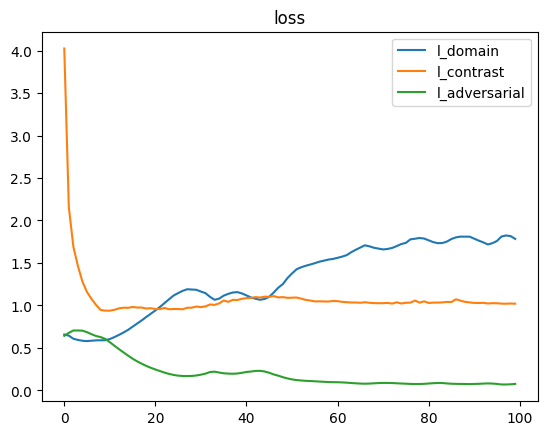

In [95]:
plt.plot(loss_domain_list)
plt.plot(loss_contrast_list)
plt.plot(loss_adversarial_list)
plt.title('loss')
plt.legend(['l_domain','l_contrast','l_adversarial'])
plt.show()

In [96]:
torch.save(encoder_t.state_dict(), os.path.join(path_model,'encoder_t.pth'))
torch.save(D.state_dict(), os.path.join(path_model,'D.pth'))

In [97]:
emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
logit_t = discriminator(data_tgt.x, emb_t).to(device)

In [102]:
from sklearn.metrics import roc_auc_score
roc_auc_score(label_tgt.detach().cpu().numpy().flatten(),logit_t.detach().cpu().numpy().flatten())

0.6920789584208317